In [43]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.base.model
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
import ml_metrics as metrics
from itertools import product
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
#import xgboost as xgb

In [44]:
def get_table(file):
    df = pd.read_csv(file, ",", parse_dates=['Date'], dayfirst=True)
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df = df.drop('index', 1)
    print( df.head())
    return df

In [45]:
def show_plot(df):
    plt.figure(figsize=(12, 7))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    df.plot(ax=ts_ax)
    smt.graphics.plot_acf(df, lags=30, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(df, lags=30, ax=pacf_ax, alpha=0.5)

    plt.tight_layout()

In [102]:
def decomposition(df, model):
    plt.figure(figsize=(12, 7))
    r = statsmodels.tsa.seasonal.seasonal_decompose(df, model=model)
    plt.plot(r.seasonal, c='red', label='Seasonal component')
    plt.plot(r.trend, label='Trend')
    plt.plot(r.resid, c='grey', label='Lags')
    plt.legend(loc='upper left')
    return r.resid['Value'], r.trend['Value'], r.seasonal['Value']

In [47]:
def train_model(df, order):
    model = sm.tsa.ARIMA(df, order=order).fit()
    print(model.summary())
    return model

def prediction(model, test, trend, seasonal):
    pred = model.predict(start=348, end=407)
    pred += trend + seasonal
    r2 = r2_score(test, pred)
    print ('R^2: %1.2f' % r2)
    print(metrics.rmse(pred, test))
    test.plot()
    pred.plot(style='r--')

In [6]:
def stationarity_test(df):
    plt.figure(figsize=(12,7))
    plt.plot(df, label="Time Series")

    rollmean = df.rolling(window=12).mean()
    ewma = df.ewm(halflife=12).mean()
    rolstd = df.rolling(window=12).std()

    plt.plot(rollmean, "g", label="Rolling mean trend")
    plt.plot(ewma, "y", label="Weighted mean trend")
    plt.plot(rolstd, "r", label="Rolling std trend")
    plt.legend(loc="upper left")

    plt.grid(True)
    plt.tight_layout()
    
    df = df.dropna()
    #Dickey-Fuller Test
    test = sm.tsa.adfuller(df)
    print ( 'adf: ', test[0])
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')
    

In [48]:
df = get_table('training.csv')
df2 = get_table('testing.csv')
df2.shape

              Value
Date               
1959-01-01  22.8331
1959-02-01  23.2802
1959-03-01  23.6156
1959-04-01  24.1186
1959-05-01  24.4820
              Value
Date               
1989-01-01  64.6158
1989-02-01  64.3268
1989-03-01  64.4548
1989-04-01  64.5270
1989-05-01  64.0662


(60, 1)

adf:  -0.253391179928
p-value:  0.931851042299
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
есть единичные корни, ряд не стационарен


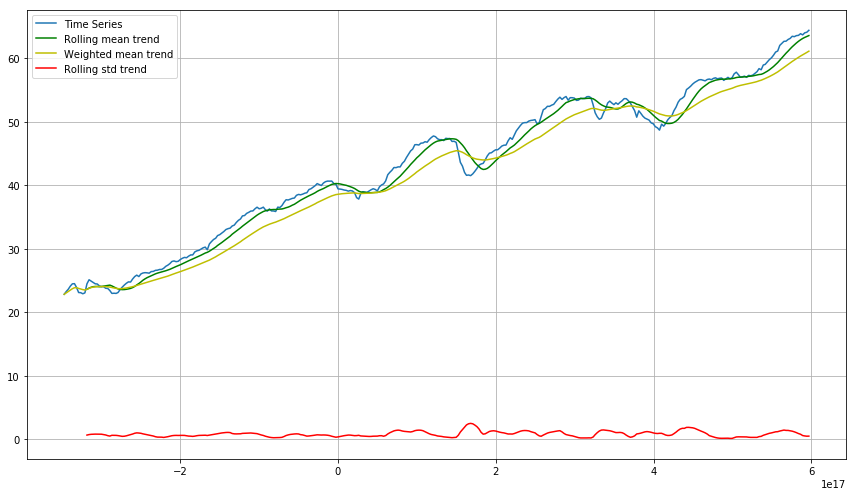

In [8]:
stationarity_test(df['Value'])

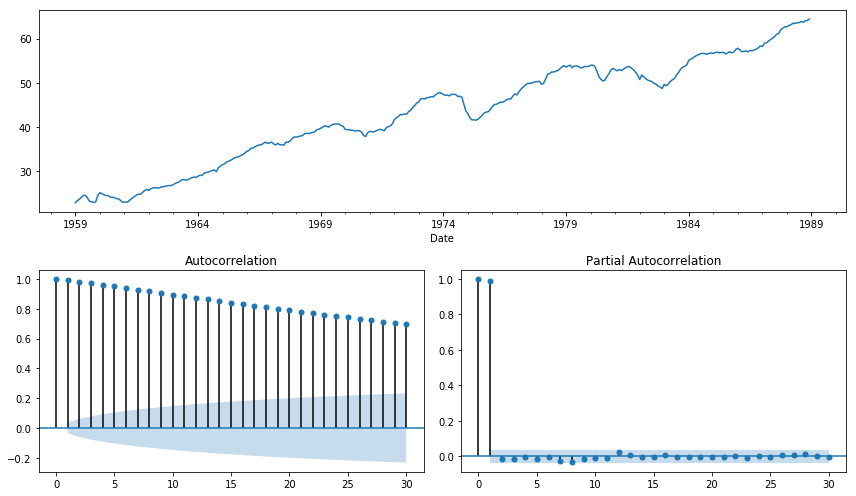

In [9]:
show_plot(df['Value'])

## Аддитивная модель

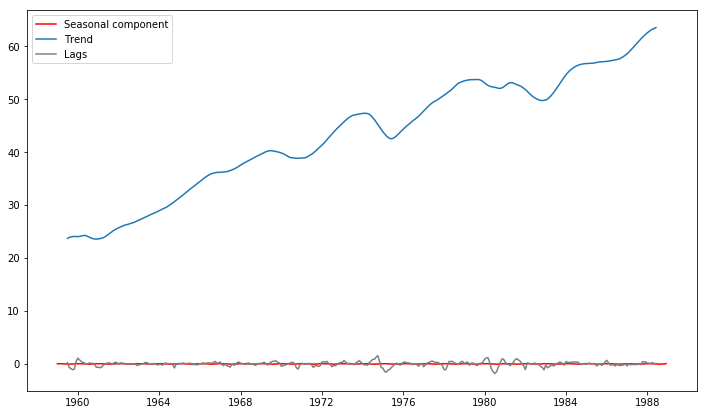

In [103]:
aresid, atrend, aseasonal = decomposition(df, 'additive')

## Мультипликативная модель

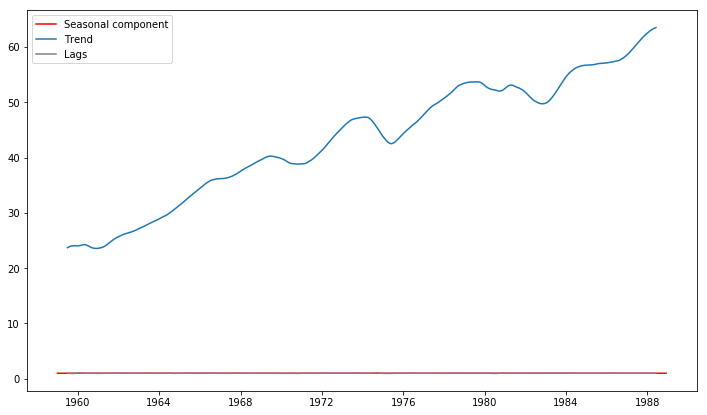

In [13]:
residual, trend, seasonal = decomposition(df, 'multiplicative')

Заметим, что в мультипликативной модели меньше разброс ошибок.

В каждой из моделей сезонность и остатки - стационарны, а тренд - не стационарен.

In [105]:
df1 = df['Value'].diff(periods=1).dropna()
df1.head()

Date
1959-02-01    0.4471
1959-03-01    0.3354
1959-04-01    0.5030
1959-05-01    0.3634
1959-06-01    0.0279
Name: Value, dtype: float64

adf:  -7.36731149521
p-value:  9.1641495611e-11
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
единичных корней нет, ряд стационарен


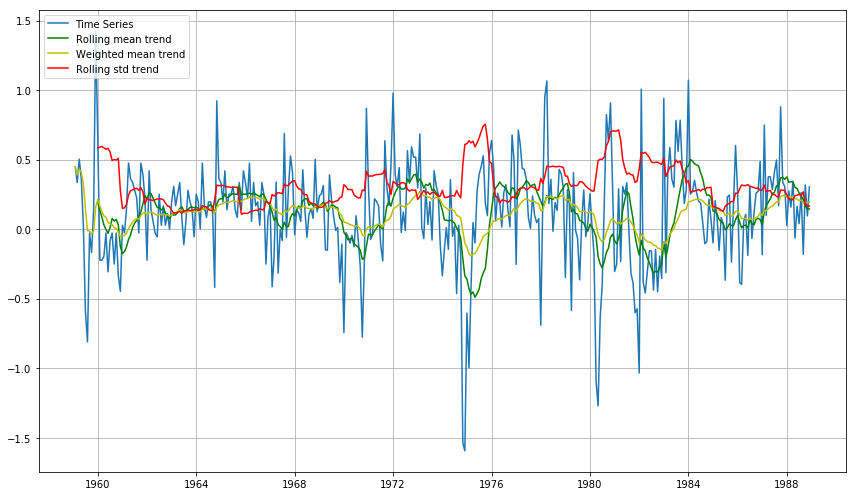

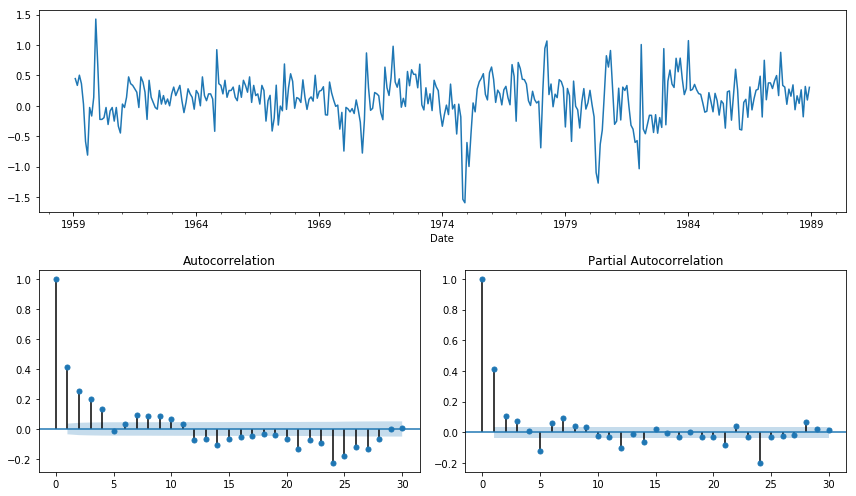

In [107]:
stationarity_test(df1)#проверка на стационарность ряда первых разностей (интегрированного ряда 1 порядка)
show_plot(df1)#интегрированный ряд первого порядка, его автокореляция и частичная автокорелляция

In [109]:
train, test = df.Value[0:-30], df.Value[329:]

### Эта херня не работает, r2_score лучше не становится

In [111]:
ps = range(1, 8)
qs = range(1, 5)

parameters = product(ps, qs)
parameters_list = list(parameters)

predictions = list()
#results = []
best_aic = float("inf")


for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.SARIMAX(train, order=(param[0],1,param[1]), seasonal_order=(param[0], 1, param[1], 12)).fit()
        #model=sm.tsa.ARIMA(train, order=(param[0], 1, param[1])).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        #results.append([param, model.aic])



  4%|▎         | 1/28 [00:01<00:31,  1.17s/it]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/anaconda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/anaconda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 11%|█         | 3/28 [00:12<01:46,  4.27s/it]/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
 18%|█▊        | 5/28 [00:18<01:23,  3.65s/it]

wrong parameters: (2, 2)


/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 32%|███▏      | 9/28 [00:41<01:27,  4.59s/it]

wrong parameters: (3, 2)


/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 46%|████▋     | 13/28 [01:18<01:30,  6.05s/it]

wrong parameters: (4, 2)
wrong parameters: (4, 3)


 57%|█████▋    | 16/28 [01:20<01:00,  5.03s/it]/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 61%|██████    | 17/28 [01:53<01:13,  6.70s/it]

wrong parameters: (5, 2)
wrong parameters: (5, 3)


 75%|███████▌  | 21/28 [02:33<00:51,  7.33s/it]/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 79%|███████▊  | 22/28 [03:35<00:58,  9.81s/it]

wrong parameters: (6, 3)


 89%|████████▉ | 25/28 [04:46<00:34, 11.47s/it]/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████| 28/28 [06:04<00:00, 13.02s/it]

wrong parameters: (7, 3)
wrong parameters: (7, 4)


In [112]:
print(best_aic, best_param)

272.905456952 (2, 1)


/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.997520586607
0.419120675807


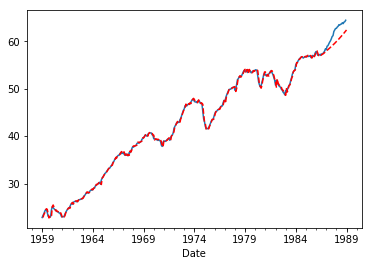

In [55]:
model = sm.tsa.SARIMAX(train, order=(5,1,0), trend=[1,1,1,1]).fit()
pr = model.predict(start = 1, end=360)
df['Value'].plot()
pr.plot(style='r--')
print(r2_score(df['Value'], pr))
print(r2_score(df.Value[-30:], pr[-30:]))

/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ValueError: Found input variables with inconsistent numbers of samples: [60, 61]

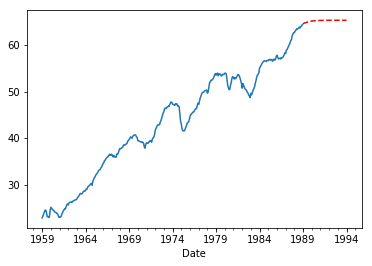

In [70]:
model = sm.tsa.SARIMAX(df['Value'], order=(8,1,3)).fit()
pr = model.predict(start = 360, end=420)
df['Value'].plot()
pr.plot(style='r--')
print(r2_score(df2['Value'], pr))

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  329
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -112.299
Method:                       css-mle   S.D. of innovations              0.340
Date:                Tue, 21 Nov 2017   AIC                            238.598
Time:                        15:51:24   BIC                            265.170
Sample:                    02-01-1959   HQIC                           249.199
                         - 06-01-1986                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1046      0.037      2.818      0.005       0.032       0.177
ar.L1.D.Value     0.4501      0.279      1.612      0.108      -0.097       0.997
ar.L2.D.Value    -0.6051      0.191     

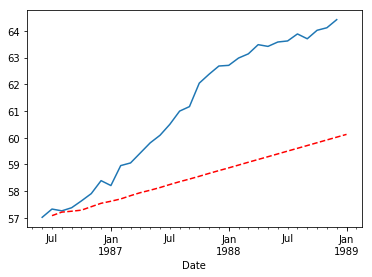

In [38]:
model = sm.tsa.ARIMA(train, order=(3,1,2)).fit()
print(model.summary())

pred = model.predict(start=330, end=360, typ='levels')
r2 = r2_score(test, pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(pred, test))
test.plot()
pred.plot(style='r--')

R^2: 1.00
0.165887230365


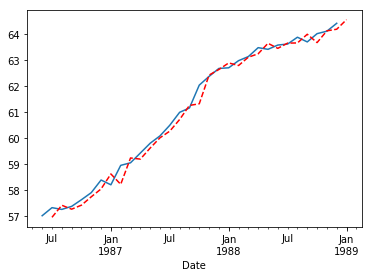

In [176]:
model1 = sm.tsa.SARIMAX(df.Value, order=(1,1,1), trend=[1,1,1,0]).fit()

pred = model1.predict(start=330, end=360)
r2 = r2_score(test, pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(test,pred))

test.plot()
pred.plot(style='r--')

R^2: 0.46
1.83823947022


/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


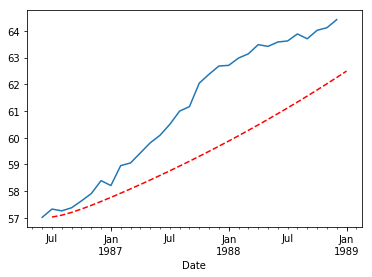

In [180]:
model1 = sm.tsa.SARIMAX(train, order=(1,1,1), trend=[1,1,1,1]).fit()
pred = model1.predict(start = 330, end=360)
r2 = r2_score(test, pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(test,pred))

test.plot()
pred.plot(style='r--')

In [265]:
model1.aic

245.65672560155119

/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


R^2: -0.15
1.89844694173


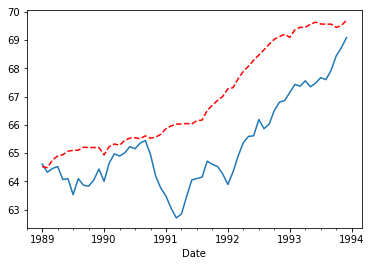

In [123]:
model1 = sm.tsa.SARIMAX(df, order=(1,1,1), seasonal_order=(9, 1, 5, 12)).fit()
pred = model1.predict(start = 360, end=419, dynamic=True, typ='levels')
r2 = r2_score(pred, df2['Value'])
print ('R^2: %1.2f' % r2)
print(metrics.rmse(df2['Value'],pred))

df2['Value'].plot()
pred.plot(style='r--')

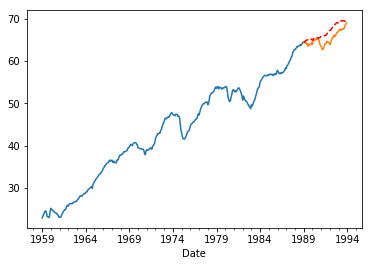

In [122]:
df['Value'].plot()
df2['Value'].plot()
pred.plot(style='r--')

In [28]:
train, test = df1.Date[0:-30], df1[329:]

model1 = sm.tsa.SARIMAX(train, order=(1,1,1), trend='c').fit()
pred = model1.predict(start = 330, end=360, dynamic=True, typ='levels')
r2 = r2_score(test, pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(df2['Value'],pred))

df2['Value'].plot()
pred.plot(style='r--')

AttributeError: 'Series' object has no attribute 'Date'

In [ ]:
#residual = residual[np.isfinite(df['Value'])]
residual = residual.fillna(method = 'bfill')
residual = residual.fillna(method = 'ffill')
#residual.dropna(inplace=True)
trend = trend.fillna(method = 'bfill')
trend = trend.fillna(method = 'ffill')
print(trend.tail())
seasonal = seasonal.fillna(method = 'bfill')
seasonal = seasonal.fillna(method = 'bfill')
#seasonal.dropna(inplace=True)
print(residual.shape)
print(trend.shape)
print(seasonal.shape)
model_r = sm.tsa.ARIMA(residual, order=(2,0,1)).fit()
model_t = sm.tsa.ARIMA(trend, order=(1,1,1)).fit()
model_s = sm.tsa.ARIMA(seasonal, order=(0,0,1)).fit()

#model = train_model(residual, order=(1,0,1))
pred = model_r.predict(start=360, end=419)
pred_t = model_t.predict(start=360, end=419)
pred_s = model_s.predict(start=360, end=419)

trend.plot(c='y')
pred_t.plot(style='r--')

#pred.plot(style='r--')
print('pred')
print(pred.tail())
print(pred_t.tail())
#pred.plot(c = "r")
#pred_t.plot(c = "g")
#pred_s.plot(c = "b")

#print(trend.tail(10))
pred = pred + pred_t + pred_s
#print(pred.tail())
pred = pred.fillna(method = 'bfill')
pred = pred.fillna(method = 'ffill')

pred.plot(c = "g")
r2 = r2_score(df2['Value'], pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(pred, df2['Value']))
df2.plot()
pred.plot(style='r--')
#prediction(model,df2['Value'],trend,seasonal)